# Download MNIST Data from Website

In [3]:
%%time
import pickle, gzip, urllib.request, json
import numpy as np

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
print(train_set[0].shape)

(50000, 784)
CPU times: user 1.05 s, sys: 441 ms, total: 1.49 s
Wall time: 3min 3s


# Explore Dataset- View 10 first images

This is a 5


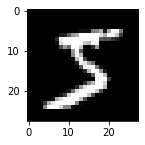

This is a 0


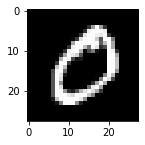

This is a 4


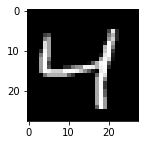

This is a 1


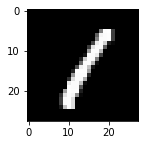

This is a 9


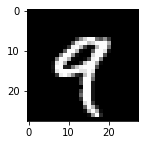

This is a 2


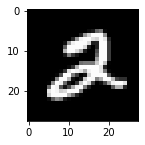

This is a 1


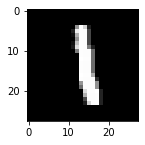

This is a 3


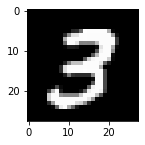

This is a 1


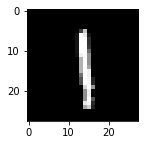

This is a 4


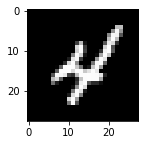

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.rcParams["figure.figsize"] = (2,10)


for i in range(0, 10):
    img = train_set[0][i]
    label = train_set[1][i]
    img_reshape = img.reshape((28,28))
    imgplot = plt.imshow(img_reshape, cmap='gray')
    print('This is a {}'.format(label))
    plt.show()

# Convert to CSV and save to S3 bucket
## Bucket: sagemaker-mnistml-learningtutorial

In [5]:
%%time


import os
import boto3
import re
import copy
import time
import io
import struct
from time import gmtime, strftime
from sagemaker import get_execution_role


role = get_execution_role()


region = boto3.Session().region_name


bucket='sagemaker-mnistml-learningtutorial' # Replace with your s3 bucket name
prefix = 'sagemaker/xgboost-mnist' # Used as part of the path in the bucket where you store data


def convert_data():
    data_partitions = [('train', train_set), ('validation', valid_set), ('test', test_set)]
    for data_partition_name, data_partition in data_partitions:
        print('{}: {} {}'.format(data_partition_name, data_partition[0].shape, data_partition[1].shape))
        labels = [t.tolist() for t in data_partition[1]]
        features = [t.tolist() for t in data_partition[0]]
        
        if data_partition_name != 'test':
            examples = np.insert(features, 0, labels, axis=1)
        else:
            examples = features
        #print(examples[50000,:])
        
        
        np.savetxt('data.csv', examples, delimiter=',')
        
        
        
        key = "{}/{}/examples".format(prefix,data_partition_name)
        url = 's3://{}/{}'.format(bucket, key)
        boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_file('data.csv')
        print('Done writing to {}'.format(url))
        
convert_data()

train: (50000, 784) (50000,)
Done writing to s3://sagemaker-mnistml-learningtutorial/sagemaker/xgboost-mnist/train/examples
validation: (10000, 784) (10000,)
Done writing to s3://sagemaker-mnistml-learningtutorial/sagemaker/xgboost-mnist/validation/examples
test: (10000, 784) (10000,)
Done writing to s3://sagemaker-mnistml-learningtutorial/sagemaker/xgboost-mnist/test/examples
CPU times: user 41.7 s, sys: 4.62 s, total: 46.3 s
Wall time: 1min 31s


# Create and Run a Training Job 
## Create Job using Python-SDK
## Deploy model with Python-SDK


In [6]:
import sagemaker

from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'xgboost')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').


In [7]:
train_data = 's3://{}/{}/{}'.format(bucket, prefix, 'train')

validation_data = 's3://{}/{}/{}'.format(bucket, prefix, 'validation')

s3_output_location = 's3://{}/{}/{}'.format(bucket, prefix, 'xgboost_model_sdk')
print(train_data)

s3://sagemaker-mnistml-learningtutorial/sagemaker/xgboost-mnist/train


In [8]:
#create sagemaker.estimator.Estimator class 
xgb_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.m4.xlarge',
                                         train_volume_size = 5,
                                         output_path=s3_output_location,
                                         sagemaker_session=sagemaker.Session())

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [9]:
# Set Hyperparameters
xgb_model.set_hyperparameters(max_depth = 5,
                              eta = .2,
                              gamma = 4,
                              min_child_weight = 6,
                              silent = 0,
                              objective = "multi:softmax",
                              num_class = 10,
                              num_round = 10)

In [10]:
# use train and validation for training job 
train_channel = sagemaker.session.s3_input(train_data, content_type='text/csv')
valid_channel = sagemaker.session.s3_input(validation_data, content_type='text/csv')

data_channels = {'train': train_channel, 'validation': valid_channel}

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [11]:
# Start model training
xgb_model.fit(inputs=data_channels,  logs=True)

2020-09-08 18:37:21 Starting - Starting the training job...
2020-09-08 18:37:23 Starting - Launching requested ML instances......
2020-09-08 18:38:33 Starting - Preparing the instances for training......
2020-09-08 18:39:46 Downloading - Downloading input data...
2020-09-08 18:40:12 Training - Downloading the training image..Arguments: train
[2020-09-08:18:40:35:INFO] Running standalone xgboost training.
[2020-09-08:18:40:35:INFO] File size need to be processed in the node: 1122.95mb. Available memory size in the node: 8490.14mb
[2020-09-08:18:40:35:INFO] Determined delimiter of CSV input is ','
[18:40:35] S3DistributionType set as FullyReplicated

2020-09-08 18:40:34 Training - Training image download completed. Training in progress.[18:40:41] 50000x784 matrix with 39200000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-09-08:18:40:41:INFO] Determined delimiter of CSV input is ','
[18:40:41] S3DistributionType set as FullyReplicated
[18:40:42]

In [12]:
# Deploy Model 
# Specify # of Instances

xgb_predictor = xgb_model.deploy(initial_instance_count=1,
                                content_type='text/csv',
                                instance_type='ml.t2.medium'
                                )

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

In [13]:
# Validate Model 

s3 = boto3.resource('s3')

test_key = "{}/test/examples".format(prefix)

s3.Bucket(bucket).download_file(test_key, 'test_data')

This is a 7


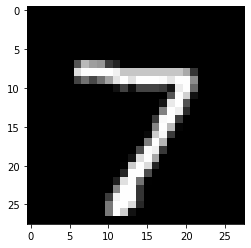

This is a 2


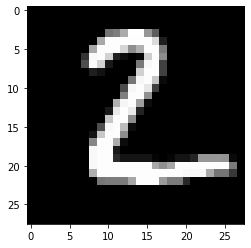

This is a 1


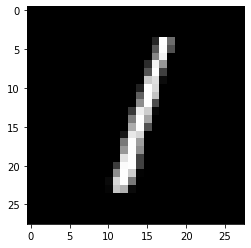

This is a 0


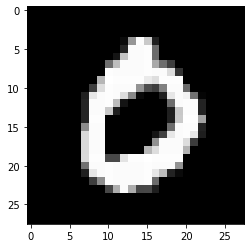

This is a 4


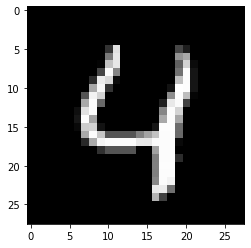

This is a 1


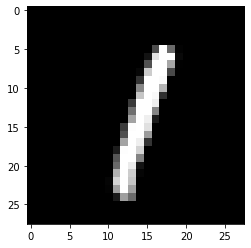

This is a 4


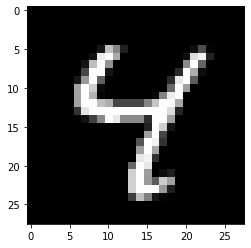

This is a 9


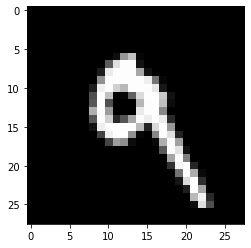

This is a 5


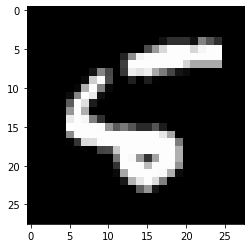

This is a 9


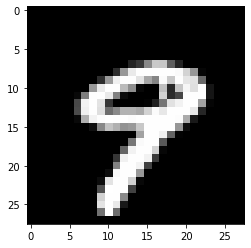

In [14]:
%matplotlib inline
                        
for i in range (0, 10):
    img = test_set[0][i]
    label = test_set[1][i]
    img_reshape = img.reshape((28,28))
    imgplot = plt.imshow(img_reshape, cmap='gray')
    print('This is a {}'.format(label))
    plt.show()

In [15]:
with open('test_data', 'r') as f:
    for j in range(0,10):
        single_test = f.readline()
        result = xgb_predictor.predict(single_test)
        print(result)

b'7.0'
b'2.0'
b'1.0'
b'0.0'
b'4.0'
b'1.0'
b'4.0'
b'9.0'
b'5.0'
b'9.0'


# Create and Run a Training Job 
## Create Job using AWS SDK for Python (Boto3)

### To train a model, SageMaker uses the CreateTrainingJob API. The AWS SDK for Python (Boto3) provides the corresponding create_training_job method.

### When using this method, you provide the following information:

- The training algorithm – Specify the registry path of the Docker image that contains the training code. For the registry paths for the algorithms provided by SageMaker, see Common parameters for built-in algorithms.

- Algorithm-specific hyperparameters – Specify algorithm-specific hyperparameters to influence the final quality of the model. For information, see XGBoost Hyperparameters.

- The input and output configuration – Provide the S3 bucket where training data is stored and where SageMaker saves the results of model training (the model artifacts).

## Validate Model 

In [16]:
#Using xgboost Container
import sagemaker

from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'xgboost')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').


In [29]:
bucket_path= "https://s3.us-west-2.amazonaws.com/"+bucket

In [30]:
#Ensure that the train and validation data folders generated above are reflected in the "InputDataConfig" parameter below.
common_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": bucket_path + "/"+ prefix + "/xgboost"
    },
    "ResourceConfig": {
        "InstanceCount": 1,   
        "InstanceType": "ml.m4.xlarge",
        "VolumeSizeInGB": 5
    },
    "HyperParameters": {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "silent":"0",
        "objective": "multi:softmax",
        "num_class": "10",
        "num_round": "10"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 86400
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/"+ prefix+ '/train/',
                    "S3DataDistributionType": "FullyReplicated" 
                }
            },
            "ContentType": "text/csv",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/"+ prefix+ '/validation/',
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "text/csv",
            "CompressionType": "None"
        }
    ]
}

In [31]:
#training job params
training_job_name = 'xgboost-mnist' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Job name is:", training_job_name)

training_job_params = copy.deepcopy(common_training_params)
training_job_params['TrainingJobName'] = training_job_name
training_job_params['ResourceConfig']['InstanceCount'] = 1

Job name is: xgboost-mnist2020-09-08-19-09-42


In [32]:
#training job 
#%%time

region = boto3.Session().region_name
sm = boto3.Session().client('sagemaker')

sm.create_training_job(**training_job_params)


status = sm.describe_training_job(TrainingJobName=training_job_name)['TrainingJobStatus']
print(status)
sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=training_job_name)
status = sm.describe_training_job(TrainingJobName=training_job_name)['TrainingJobStatus']
print("Training job ended with status: " + status)
if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=training_job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')

InProgress
Training job ended with status: Completed


In [37]:
model_name = training_job_name + '-mod'

info = sm.describe_training_job(TrainingJobName=training_job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = sm.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

https://s3.us-west-2.amazonaws.com/sagemaker-mnistml-learningtutorial/sagemaker/xgboost-mnist/xgboost/xgboost-mnist2020-09-08-19-09-42/output/model.tar.gz
arn:aws:sagemaker:us-west-2:821133245089:model/xgboost-mnist2020-09-08-19-09-42-mod


In [38]:
endpoint_config_name = 'DEMO-XGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialVariantWeight':1,
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

DEMO-XGBoostEndpointConfig-2020-09-08-19-19-17
Endpoint Config Arn: arn:aws:sagemaker:us-west-2:821133245089:endpoint-config/demo-xgboostendpointconfig-2020-09-08-19-19-17


In [41]:
# Create Endpoint
import time
#%%time

endpoint_name = 'DEMO-XGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sm.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sm.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = sm.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

DEMO-XGBoostEndpoint-2020-09-08-19-19-39
arn:aws:sagemaker:us-west-2:821133245089:endpoint/demo-xgboostendpoint-2020-09-08-19-19-39
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-west-2:821133245089:endpoint/demo-xgboostendpoint-2020-09-08-19-19-39
Status: InService


In [42]:
# Get Test data
s3 = boto3.resource('s3')

test_key = "{}/test/examples".format(prefix)

s3.Bucket(bucket).download_file(test_key, 'test_data')

This is a 7


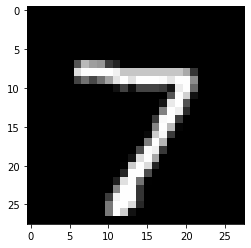

This is a 2


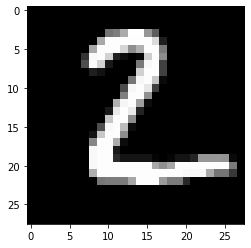

This is a 1


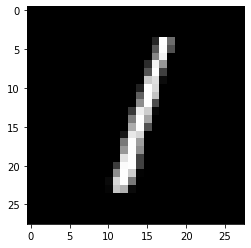

This is a 0


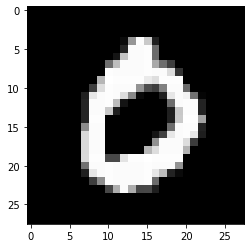

This is a 4


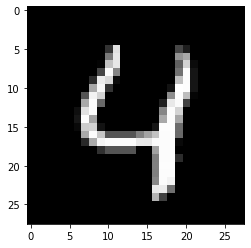

This is a 1


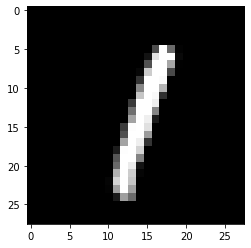

This is a 4


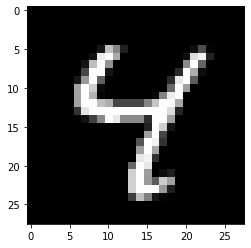

This is a 9


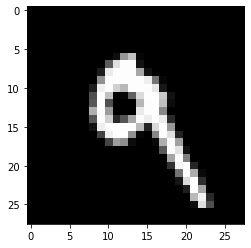

This is a 5


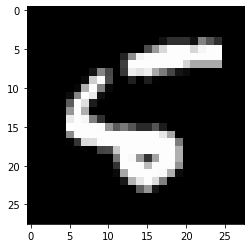

This is a 9


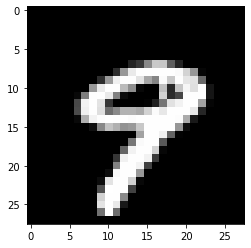

In [43]:
%matplotlib inline
                        
for i in range (0, 10):
    img = test_set[0][i]
    label = test_set[1][i]
    img_reshape = img.reshape((28,28))
    imgplot = plt.imshow(img_reshape, cmap='gray')
    print('This is a {}'.format(label))
    plt.show()

In [44]:
runtime_client = boto3.client('runtime.sagemaker')

In [45]:
with open('test_data', 'r') as f:
    
    for i in range(0,10):
        single_test = f.readline()
        response = runtime_client.invoke_endpoint(EndpointName = endpoint_name,
                                         ContentType = 'text/csv',
                                         Body = single_test)
        result = response['Body'].read().decode('ascii')
        print('Predicted label is {}.'.format(result))

Predicted label is 7.0.
Predicted label is 2.0.
Predicted label is 1.0.
Predicted label is 0.0.
Predicted label is 4.0.
Predicted label is 1.0.
Predicted label is 4.0.
Predicted label is 9.0.
Predicted label is 5.0.
Predicted label is 9.0.


In [1]:
!jupyter nbconvert --to script MNIST-Tutorial-OnlineAWSNotebook.ipynb

[TerminalIPythonApp] WARNING | Subcommand `ipython nbconvert` is deprecated and will be removed in future versions.
[TerminalIPythonApp] WARNING | You likely want to use `jupyter nbconvert` in the future
[NbConvertApp] Converting notebook MNIST-Tutorial-OnlineAWSNotebook.ipynb to script
[NbConvertApp] Writing 11811 bytes to MNIST-Tutorial-OnlineAWSNotebook.py
